In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib.gridspec as gridspec
import random
from astroML.correlation import two_point
from scipy.optimize import curve_fit
import os
import subprocess

# Compute the galaxy positions at fixed abundance
### For z = 0.20, 0.50, 1.00, and 2.00 at n =  $\sim$0.33, $\sim$0.14, and 0.03 Galaxy/Mpc$^3$, including red and blue galaxies

In [2]:
# iterate through each redshift
for z in [0.20,0.50,1.00,2.00]:
    
    z="{:.2f}".format(z) 
    cdm_galaxy = h5py.File('Data/n/home07/sbose/COLOR_CDM_Galaxies_z'+z+'.hdf5', 'r')
    wdm_galaxy = h5py.File('Data/n/home07/sbose/COLOR_WDM_Galaxies_z'+z+'.hdf5', 'r')
    
    # Access color/position/mass for wdm/cdm
    cdm_galaxy_color = cdm_galaxy['Colour'][:]
    cdm_galaxy_position = cdm_galaxy['GalaxyPos'][:]
    cdm_galaxy_mass = cdm_galaxy['StellarMass'][:]

    wdm_galaxy_color = wdm_galaxy['Colour'][:]
    wdm_galaxy_position = wdm_galaxy['GalaxyPos'][:]
    wdm_galaxy_mass = wdm_galaxy['StellarMass'][:]
    
    # sort in order of descending mass
    cdm_ind = sorted(range(len(cdm_galaxy_mass)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
    wdm_ind = sorted(range(len(wdm_galaxy_mass)), key=lambda k: wdm_galaxy_mass[k], reverse = True)
    
    # sanity check
    cdm_galaxy_mass_sorted, wdm_galaxy_mass_sorted = cdm_galaxy_mass[cdm_ind], wdm_galaxy_mass[wdm_ind]
    cdm_check = all(cdm_galaxy_mass_sorted[i] >= cdm_galaxy_mass_sorted[i+1] for i in range(len(cdm_ind)-1))
    wdm_check = all(wdm_galaxy_mass_sorted[i] >= wdm_galaxy_mass_sorted[i+1] for i in range(len(wdm_ind)-1))
    if (cdm_check==False) | (wdm_check==False): 
        print('General sanity check failed!')
        
    # define the red and blue galaxies for CDM
    cdm_blue = np.array(cdm_galaxy_color)[np.where(cdm_galaxy_color < 0.5)]
    cdm_red = np.array(cdm_galaxy_color)[np.where(cdm_galaxy_color > 0.5)]

    # define the red and blue galaxies for WDM
    wdm_blue = np.array(wdm_galaxy_color)[np.where(wdm_galaxy_color < 0.5)]
    wdm_red = np.array(wdm_galaxy_color)[np.where(wdm_galaxy_color > 0.5)]
    
    # sort the blue galaxies in order of descending mass
    cdm_blue_ind = sorted(range(len(cdm_blue)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
    wdm_blue_ind = sorted(range(len(wdm_blue)), key=lambda k: wdm_galaxy_mass[k], reverse = True)

    # sort the red galaxies in order of descending mass
    cdm_red_ind = sorted(range(len(cdm_red)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
    wdm_red_ind = sorted(range(len(wdm_red)), key=lambda k: wdm_galaxy_mass[k], reverse = True)

    # sanity check
    check = np.array([len(np.where(cdm_galaxy_color[cdm_blue_ind]>0.5)[0]),
                      len(np.where(wdm_galaxy_color[wdm_blue_ind]<0.5)[0]),
                      len(np.where(cdm_galaxy_color[cdm_red_ind]>0.5)[0]),
                      len(np.where(wdm_galaxy_color[wdm_red_ind]<0.5)[0])])
    if check.any()!=np.zeros(len(check)).any():
        print('Color sanity check failed!')
                          
    # Create an input folder 
    home="C:\\Users\\shife\\OneDrive\\Harvard_Stuff\\Astro_98"
    folder=home+"\\Input\\redshift\\"
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    # iterate through each galaxy number density
    for n in [326952,136834,30000]:

        # label the galaxy positions correctly
        label="_galaxy_position_z"+z+"_n{:.2f}".format(n/100**3)+".txt"
    
        # save the galaxy positions
        np.savetxt(folder+"cdm"+label, cdm_galaxy_position[cdm_ind[:n]], fmt = "%f %f %f")
        np.savetxt(folder+"wdm"+label, wdm_galaxy_position[wdm_ind[:n]], fmt = "%f %f %f")

        # save the blue galaxy positions
        np.savetxt(folder+"cdm_blue"+label, cdm_galaxy_position[cdm_blue_ind[:n]], fmt = "%f %f %f")
        np.savetxt(folder+"wdm_blue"+label, wdm_galaxy_position[wdm_blue_ind[:n]], fmt = "%f %f %f")

        # save the red galaxy positions
        np.savetxt(folder+"cdm_red"+label, cdm_galaxy_position[cdm_red_ind[:n]], fmt = "%f %f %f")
        np.savetxt(folder+"wdm_red"+label, wdm_galaxy_position[wdm_red_ind[:n]], fmt = "%f %f %f")
        
# Zip each input file
os.chdir(folder)
for file in os.listdir(folder):
    if file.endswith('.txt'):
        subprocess.call(['zip','-ur','redshift.zip',file])
os.chdir(home)

Color sanity check failed!
Color sanity check failed!
Color sanity check failed!
Color sanity check failed!


# Plot the Correlation Function
### Import the output data from Odyssey

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


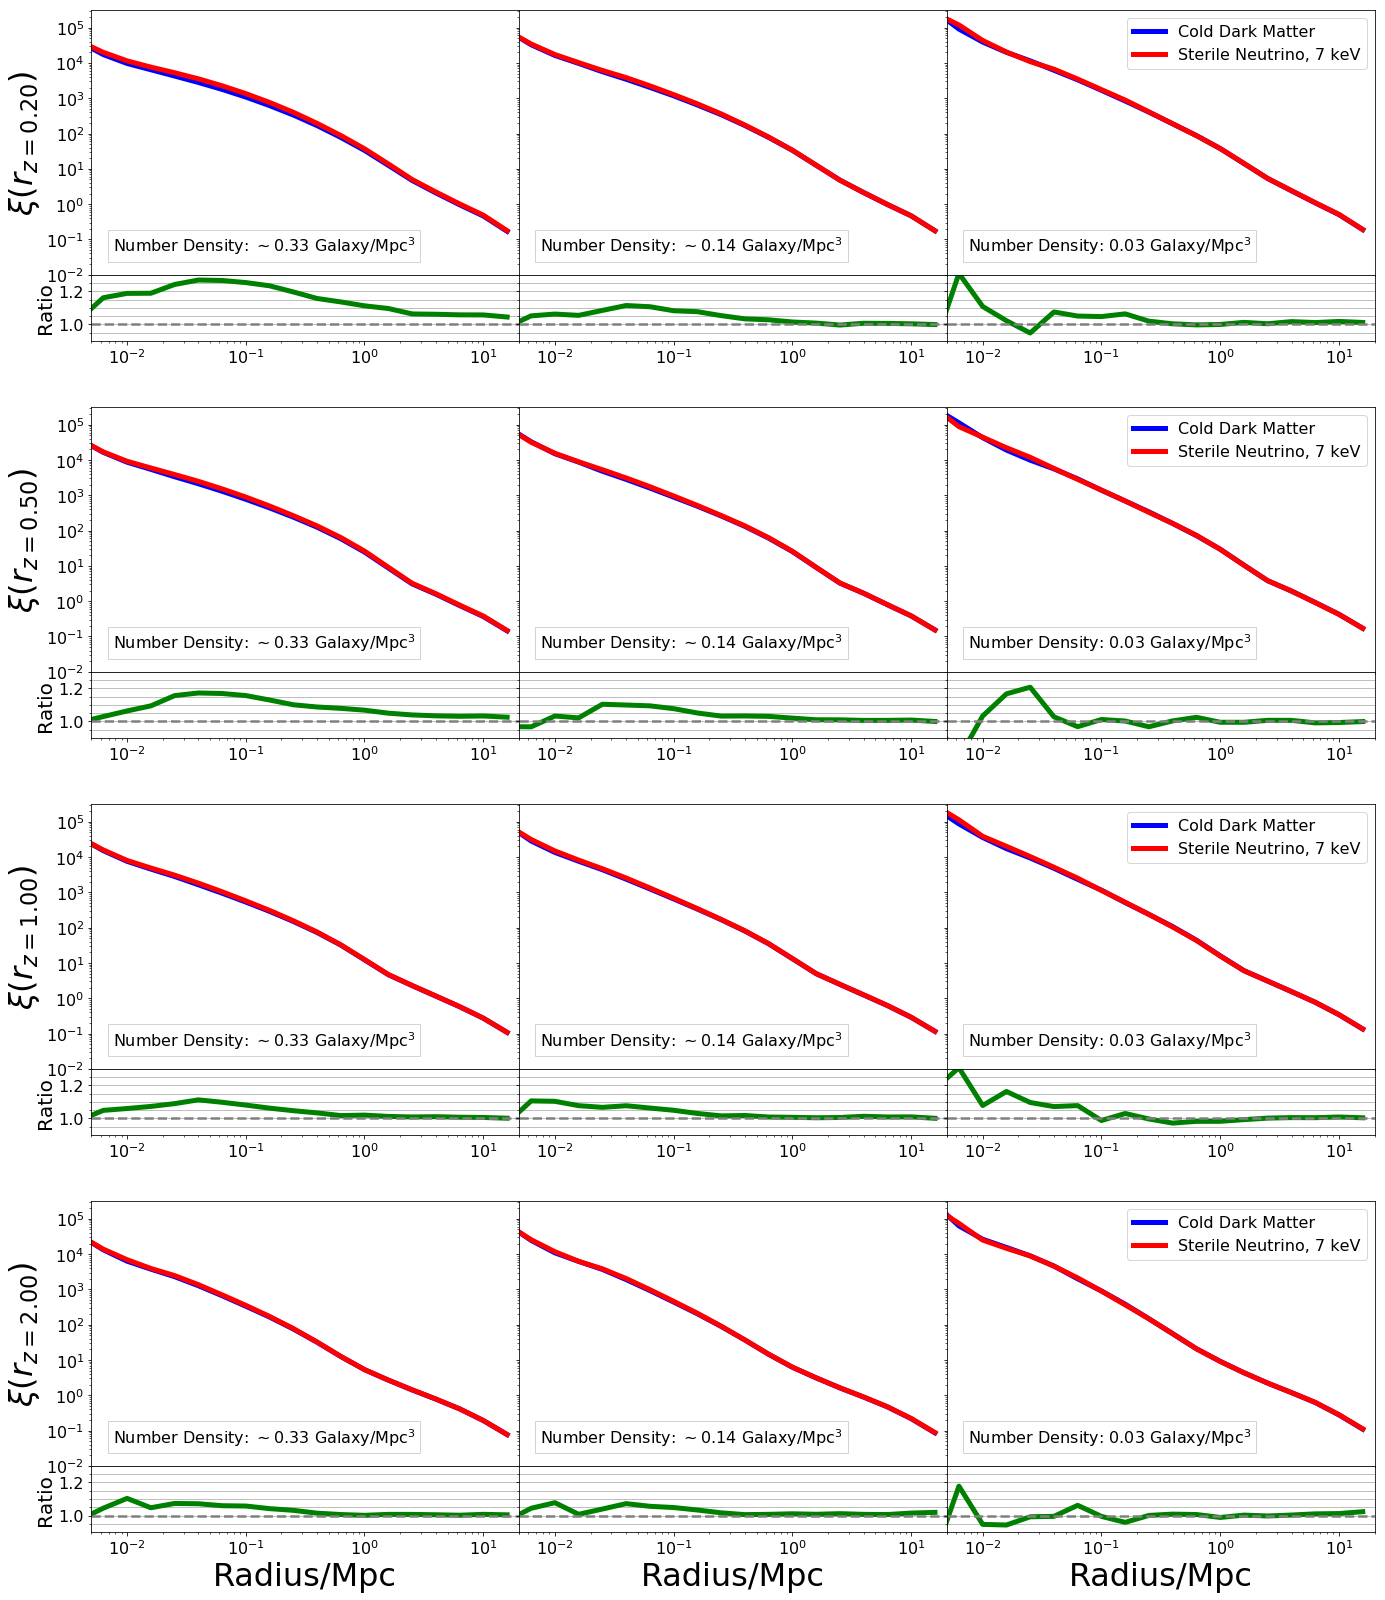

In [3]:
fig = plt.figure(figsize = (23,28)) # 30,32 #21,30 #23,28
gs = gridspec.GridSpec(4, 1)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)
        
    # load data
    CUTE_cdm_n1 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.33.txt")
    CUTE_wdm_n1 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.33.txt")

    CUTE_cdm_n2 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.14.txt")
    CUTE_wdm_n2 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.14.txt")

    CUTE_cdm_n3 = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n0.03.txt")
    CUTE_wdm_n3 = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n0.03.txt")

    grid = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                            height_ratios=[4,1])

    # first grid
    grid0 = fig.add_subplot(grid[0])
    grid0.loglog(CUTE_cdm_n1[:,0], CUTE_cdm_n1[:,1], linewidth = 5, color = "blue")
    grid0.loglog(CUTE_wdm_n1[:,0], CUTE_wdm_n1[:,1], linewidth = 5, color = "red")
    grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)

    # second grid
    grid1 = fig.add_subplot(grid[1])
    grid1.loglog(CUTE_cdm_n2[:,0], CUTE_cdm_n2[:,1], linewidth = 5, color = "blue")
    grid1.loglog(CUTE_wdm_n2[:,0], CUTE_wdm_n2[:,1], linewidth = 5, color = "red")

    # third grid
    grid2 = fig.add_subplot(grid[2])
    grid2.loglog(CUTE_cdm_n3[:,0], CUTE_cdm_n3[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
    grid2.loglog(CUTE_wdm_n3[:,0], CUTE_wdm_n3[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
                 color = "red")
    grid2.legend(fontsize = 16)
    
    # fourth grid
    grid3 = fig.add_subplot(grid[3], sharex=grid0)
    grid3.semilogx(CUTE_cdm_n1[:,0], CUTE_wdm_n1[:,1]/CUTE_cdm_n1[:,1], linewidth = 5, color = "green")
    grid3.set_ylabel("Ratio", fontsize = 20)

    # fifth grid
    grid4 = fig.add_subplot(grid[4])
    grid4.semilogx(CUTE_cdm_n2[:,0], CUTE_wdm_n2[:,1]/CUTE_cdm_n2[:,1], linewidth = 5, color = "green")
    
    # sixth grid
    grid5 = fig.add_subplot(grid[5])
    grid5.semilogx(CUTE_cdm_n3[:,0], CUTE_wdm_n3[:,1]/CUTE_cdm_n3[:,1], linewidth = 5, color = "green")

    # details
    for n,grid,offset in zip(['$\sim$0.33','$\sim$0.14','0.03'],[grid0,grid1,grid2],[0,1,2]):
        textstr = r'Number Density: '+n+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
        grid.text(0.05+offset, 0.15, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid.set_ylim(10**-2, 10**5.5)  
            
    for grid in [grid3,grid4,grid5]:
        grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid.set_ylim(0.9, 1.3)
        grid.yaxis.grid(which = "both")
        
        if i==3:
            grid.set_xlabel("Radius/Mpc", fontsize = 32)

    for grid in [grid1,grid2,grid4,grid5]:
        grid.set_yticklabels([])
        
    for grid in [grid0,grid1,grid2,grid3,grid4,grid5]:
        grid.tick_params(labelsize=16)
        grid.set_xlim(5*10**-3, 2e1)
        grid.minorticks_on()   
        
    i+=1

plt.savefig('Images/Summer2020/Redshift.pdf')        
plt.show()

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


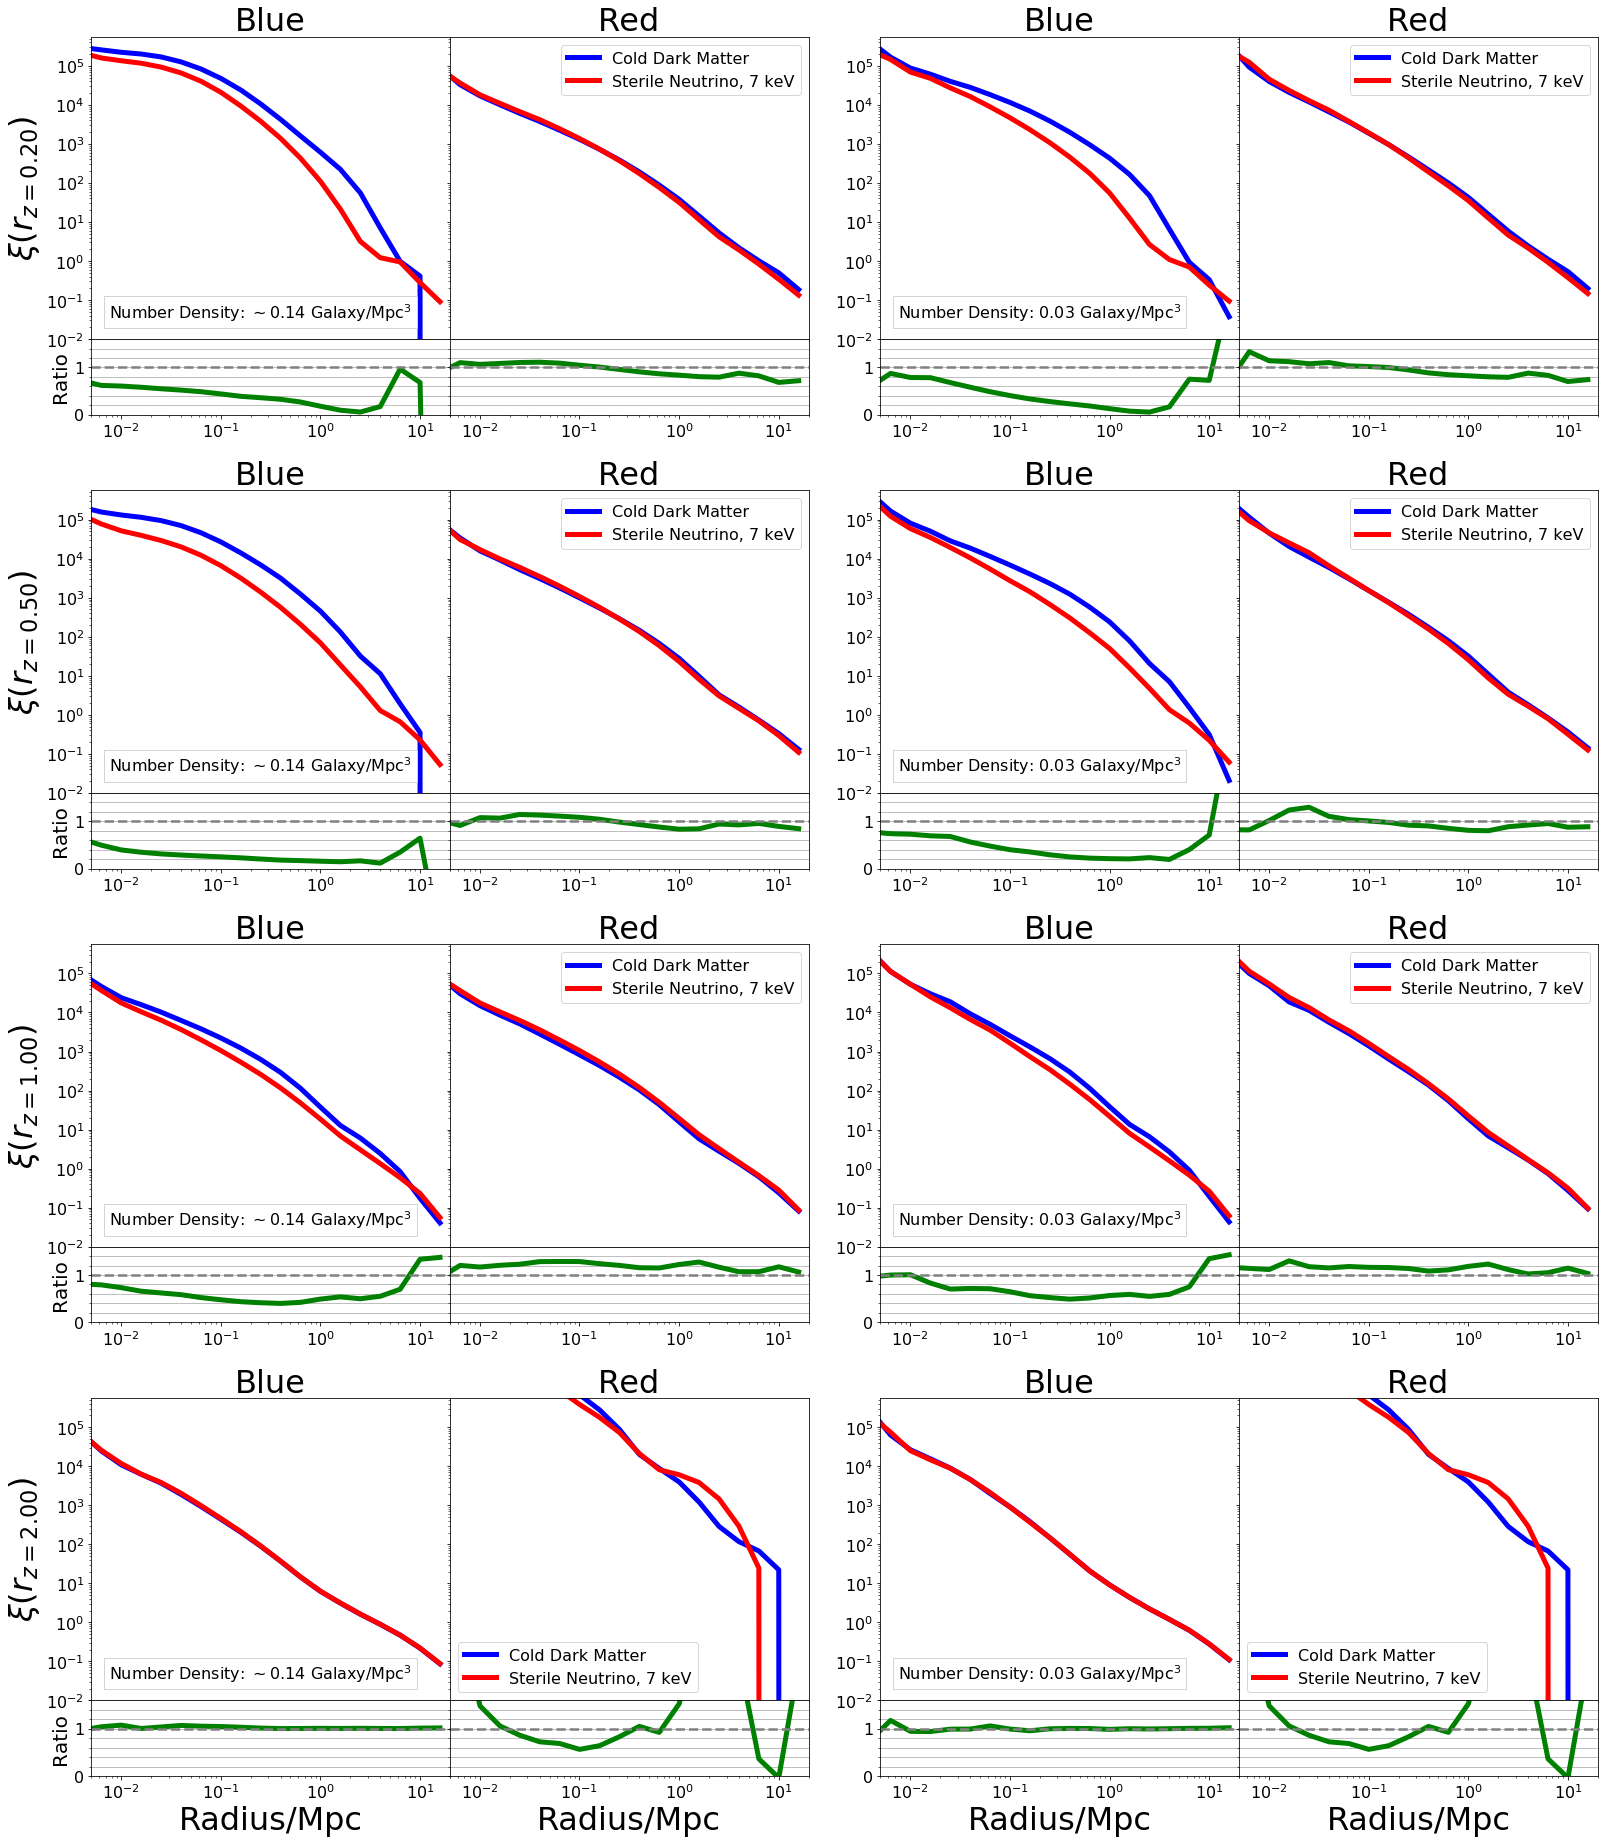

In [4]:
fig = plt.figure(figsize = (27, 32)) #28,40 #25,30
gs = gridspec.GridSpec(4, 2)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.14,0.03],['$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        root = "Output/redshift/redshift_v1/corr_"
        CUTE_cdm_blue = np.genfromtxt(root+"cdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_blue = np.genfromtxt(root+"wdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        
        CUTE_cdm_red = np.genfromtxt(root+"cdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_red = np.genfromtxt(root+"wdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                                height_ratios=[4,1])
        
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid0.text(0.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid0.set_title('Blue',fontsize=32)
        
        # second grid
        grid1 = fig.add_subplot(grid[1])
        grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid1.legend(fontsize = 16)
        grid1.set_title('Red',fontsize=32)

        # third grid
        grid2 = fig.add_subplot(grid[2], sharex=grid0)
        grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, 
                       color = "green")
        
        # fourth grid
        grid3 = fig.add_subplot(grid[3])
        grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, 
                       color = "green")
        
        # details
        for grid in [grid0,grid1]:
            grid.set_ylim(10**-2, 10**5.75)
            
        for grid in [grid2,grid3]:
            grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
            grid.set_ylim(0, 1.6)
            grid.yaxis.grid(which = "both")
            
        for grid in [grid1,grid3]:
            grid.set_yticklabels([])
        
        for grid in [grid0,grid1,grid2,grid3]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
        
        if i%2==0:
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid2.set_ylabel("Ratio", fontsize = 20)            
        if i>5:
            grid2.set_xlabel("Radius/Mpc", fontsize = 32)
            grid3.set_xlabel("Radius/Mpc", fontsize = 32)
        i+=1
    
gs.update(wspace=0.1)
plt.savefig('Images/Summer2020/Redshift_Color.pdf')   
plt.show()

# Calculate the correlation length and slope
### Define the power law function

In [5]:
def log_xi(r,r0,gamma):
    return np.log10((r/r0)**(-gamma))

In [6]:
print('Calculating the correlation length and slope...\n')

covar_r0,covar_gamma=[],[]

# loop over the redshifts
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    # loop over the galaxy number densities
    for n in [326952,136834,30000]:
        
        n='{:.2f}'.format(n/(100**3))
        
        # loop over cdm and wdm
        for label,tag in zip(['cdm','wdm'],['z='+z,'n='+n+' Galaxy/Mpc^3']):
            
            # load data
            CUTE_sorted = np.genfromtxt("Output/redshift/corr_"+label+"_galaxy_position_z"+z+"_n"+n+".txt")

            # calculate the best fit correlation length and slope
            ydata = np.log10(CUTE_sorted[:,1])
            params = curve_fit(log_xi, CUTE_sorted[:,0][ydata!=-np.inf], ydata[ydata!=-np.inf], 
                               p0 = [7.5, 1.5], xtol = 1e-10, ftol = 1e-10)
            
            # print the best fit correlation length and slope
            r0=': r0={:<10.3f}'.format(params[0][0])
            gamma='gamma={:<9.3f}'.format(params[0][1])
            covar='Covariance: {:<9.3f}{:<9.3f}'.format(*np.sqrt(np.diag(params[1])))
            
            print('{:<23}'.format(tag)+label.upper()+r0+gamma+covar)
            
            # calculate the average covariance
            covar_r0.append(np.sqrt(np.diag(params[1]))[0])
            covar_gamma.append(np.sqrt(np.diag(params[1]))[1])

        print()
        
print('Average covariance: {:<9.3f}{:<9.3f}'.format(*[np.mean(covar_r0),np.mean(covar_gamma)]))

Calculating the correlation length and slope...

z=0.20                 CDM: r0=10.134    gamma=1.351    Covariance: 1.895    0.042    
n=0.33 Galaxy/Mpc^3    WDM: r0=11.556    gamma=1.330    Covariance: 2.535    0.047    

z=0.20                 CDM: r0=8.664     gamma=1.471    Covariance: 1.128    0.032    
n=0.14 Galaxy/Mpc^3    WDM: r0=8.860     gamma=1.469    Covariance: 1.165    0.032    

z=0.20                 CDM: r0=7.536     gamma=1.663    Covariance: 0.569    0.022    
n=0.03 Galaxy/Mpc^3    WDM: r0=7.339     gamma=1.687    Covariance: 0.417    0.017    

z=0.50                 CDM: r0=8.712     gamma=1.332    Covariance: 1.676    0.041    
n=0.33 Galaxy/Mpc^3    WDM: r0=8.869     gamma=1.345    Covariance: 1.495    0.036    

z=0.50                 CDM: r0=7.052     gamma=1.501    Covariance: 0.841    0.033    
n=0.14 Galaxy/Mpc^3    WDM: r0=7.347     gamma=1.486    Covariance: 1.011    0.035    

z=0.50                 CDM: r0=6.511     gamma=1.695    Covariance: 0.421   

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


### Check the fit visually

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


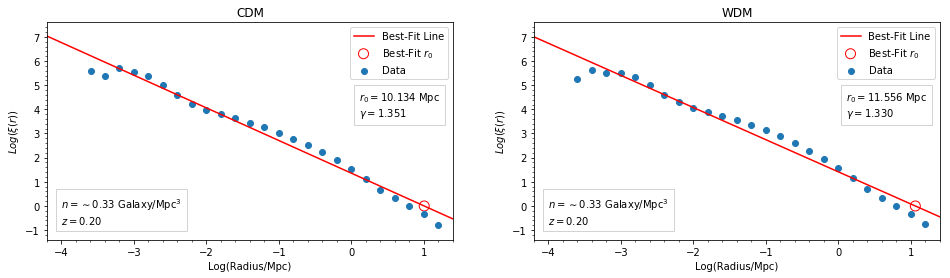

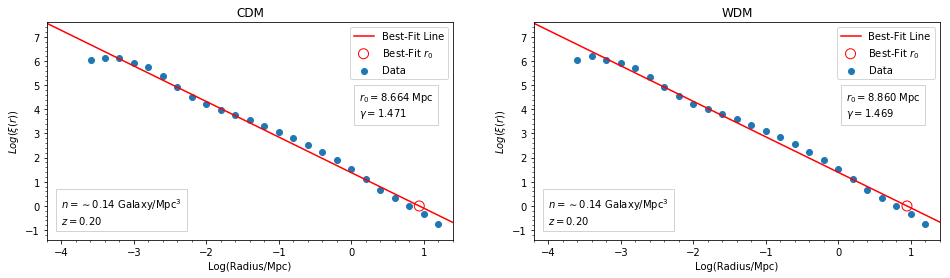

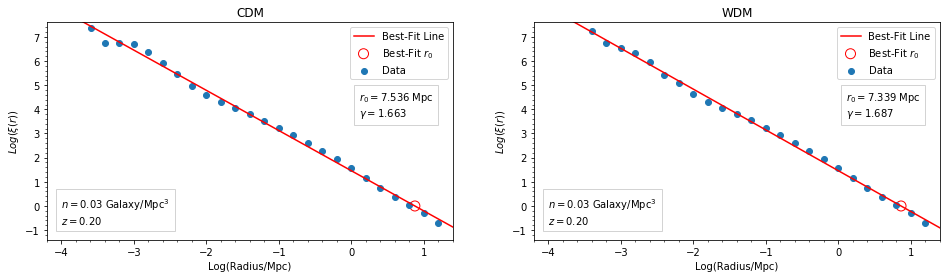

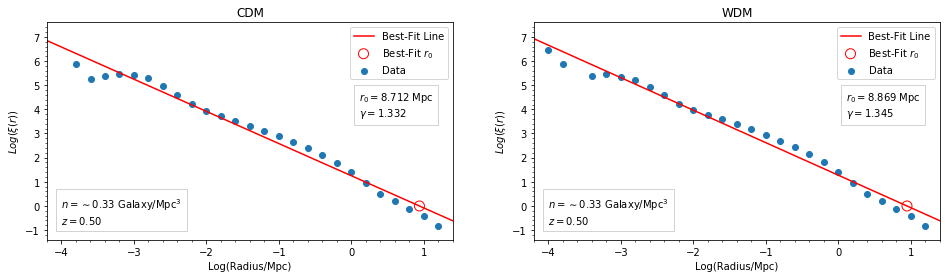

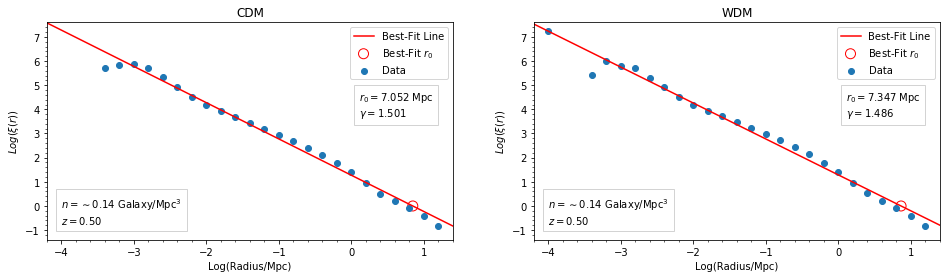

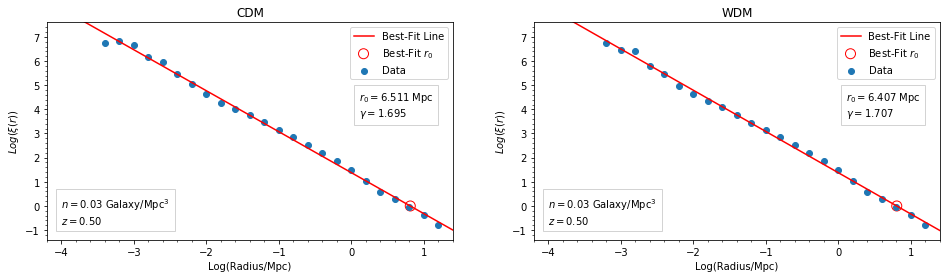

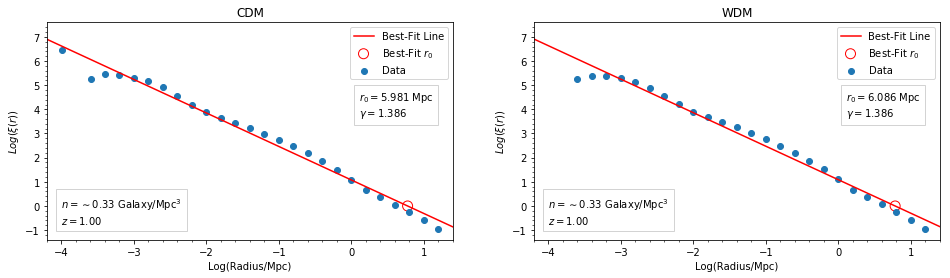

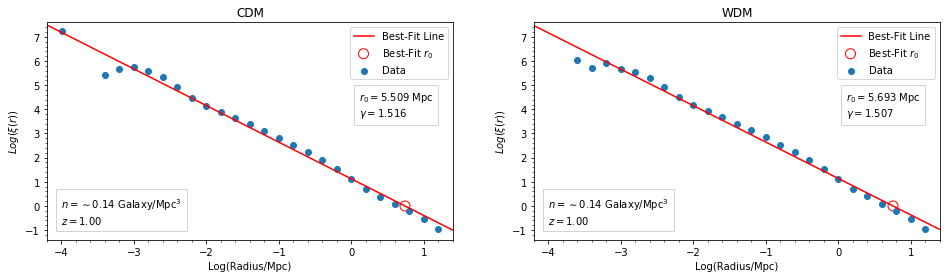

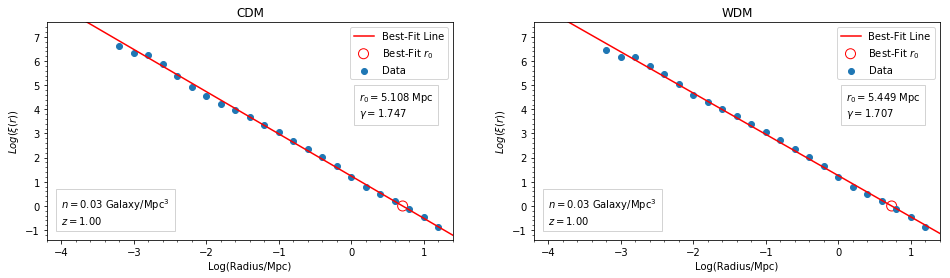

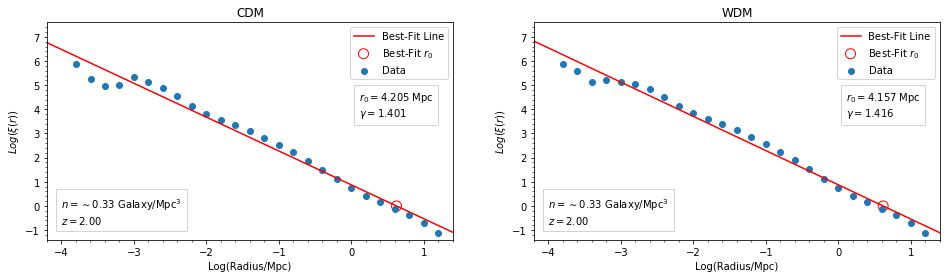

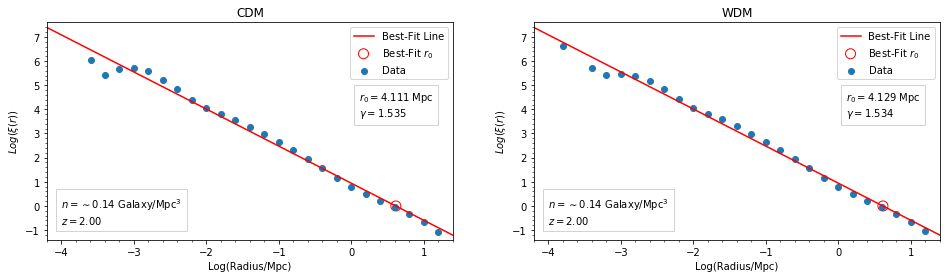

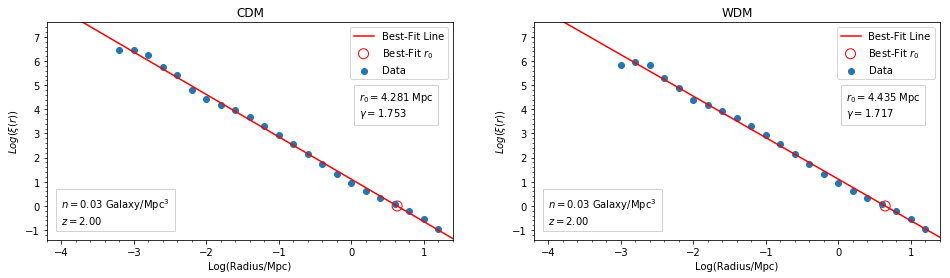

In [7]:
#loop over the redshifts
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    # loop over the galaxy number densities
    for n,n_text in zip([326952,136834,30000],['\sim','\sim',' ']):
        
        n='{:.2f}'.format(n/(100**3))
              
        # set up the plots
        plt.figure(figsize=(16,4))
        grid = gridspec.GridSpec(1,2)
        grid.update(hspace = 0)
        grid0 = plt.subplot(grid[0])
        grid1 = plt.subplot(grid[1])
        
        # loop over cdm and wdm
        for label,grid in zip(['cdm','wdm'],[grid0,grid1]):
            
            # load data
            CUTE_sorted = np.genfromtxt("Output/redshift/corr_"+label+"_galaxy_position_z"+z+"_n"+n+".txt")

            # calculate the best fit correlation length and slope
            ydata = np.log10(CUTE_sorted[:,1])
            params = curve_fit(log_xi, CUTE_sorted[:,0][ydata!=-np.inf], ydata[ydata!=-np.inf], 
                               p0 = [7.5, 1.5], xtol = 1e-10, ftol = 1e-10)
            r0, gamma = params[0][0], params[0][1]
            
            # label the plots
            textstr1 = '\n'.join((
                r'$n='+n_text+n+'$ Galaxy/Mpc$^{3}$',
                r'$z=$'+z))
            textstr2 = '\n'.join((
                r'$r_0=${:.3f} Mpc'.format(params[0][0]),
                r'$\gamma=${:<.3f}'.format(params[0][1])))
            props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
        
            # plot the best fit correlation length and slope
            x_fit, r0_fit = np.logspace(-4.2,1.4), np.log10(r0)
            grid.scatter(r0_fit, 0, color = 'red', label = 'Best-Fit $r_0$', facecolors = 'None', s = 100)
            grid.plot(np.log10(x_fit), log_xi(x_fit, r0, gamma), label = 'Best-Fit Line', color = 'red') 
            grid.scatter(np.log10(CUTE_sorted[:,0]), ydata, label = "Data")
            grid.text(-4, 0.5, textstr1, verticalalignment='top', bbox=props) #-3.25,0.7 #-0.45,5.1 #-3.25,0.7
            grid.text(0.1, 4.8, textstr2, verticalalignment='top', bbox=props)#-3.25,2.5 #-3.25,0.7 #0.25,4/5.2
            grid.set_xlabel('Log(Radius/Mpc)')
            grid.set_ylabel(r"$Log(\xi(r))$")
            grid.set_title(label.upper())
            grid.set_xlim(-4.2, 1.4) #-3.5, 2
            grid.set_ylim(-1.4, 7.6) #-1, 7
            grid.minorticks_on()
            grid.legend()
        
        plt.show()

# Calculate the percentage of satellite galaxies
### Repeat for each model

In [8]:
print('Calculating the percentage of satellites...\n')

for z in [0.2,0.5,1.00,2.00]:
    
    # repeat for all redshifts
    z="{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n in [326952,136834,30000]:
        
        # loop over cdm and wdm
        for label,tag in zip(['CDM','WDM'],['z='+z,'n={:.2f}'.format(n/(100**3))+' Galaxy/Mpc^3']):
    
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')

            # access galaxy mass
            galaxy_mass = galaxy['StellarMass'][:]

            # sort in order of descending mass
            ind_sorted = sorted(range(len(galaxy_mass)), key=lambda k: galaxy_mass[k], reverse = True)

            # calculate the number of satellite galaxies
            iscentral=galaxy['IsCentral'][:][ind_sorted[:n]]
            
            # sanity check
            galaxy_mass_sorted = galaxy_mass[ind_sorted]
            check = all(galaxy_mass_sorted[i] >= galaxy_mass_sorted[i+1] for i in range(len(ind_sorted)-1))
            if check==False: 
                print('General sanity check failed!')
            
            print('{:<23}'.format(tag)+label
                  +': {:<9.3f} N_gal: {:<9}'.format(len(iscentral[iscentral==0])*100/n, len(iscentral)))
            
        print()

Calculating the percentage of satellites...

z=0.20                 CDM: 49.442    N_gal: 326952   
n=0.33 Galaxy/Mpc^3    WDM: 53.032    N_gal: 326952   

z=0.20                 CDM: 44.893    N_gal: 136834   
n=0.14 Galaxy/Mpc^3    WDM: 45.607    N_gal: 136834   

z=0.20                 CDM: 38.280    N_gal: 30000    
n=0.03 Galaxy/Mpc^3    WDM: 38.120    N_gal: 30000    

z=0.50                 CDM: 45.804    N_gal: 326952   
n=0.33 Galaxy/Mpc^3    WDM: 47.943    N_gal: 326952   

z=0.50                 CDM: 42.249    N_gal: 136834   
n=0.14 Galaxy/Mpc^3    WDM: 42.901    N_gal: 136834   

z=0.50                 CDM: 35.770    N_gal: 30000    
n=0.03 Galaxy/Mpc^3    WDM: 35.520    N_gal: 30000    

z=1.00                 CDM: 40.845    N_gal: 326952   
n=0.33 Galaxy/Mpc^3    WDM: 41.851    N_gal: 326952   

z=1.00                 CDM: 37.493    N_gal: 136834   
n=0.14 Galaxy/Mpc^3    WDM: 37.974    N_gal: 136834   

z=1.00                 CDM: 31.560    N_gal: 30000    
n=0.03 Galax

### Including red and blue galaxies

In [9]:
print('Calculating the percentage of satellites in red and blue galaxies...\n')
print('{:<23}'.format(' ')+'{:<15}'.format('Blue')+'{:<15}'.format('Red')+'{:<17}'.format('Blue')+'Red\n')

for z in [0.2,0.5,1.00,2.00]:
    
    # repeat for all redshifts
    z="{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n in [136834,30000]:
        
        for label,tag in zip(['CDM','WDM'],['z='+z,'n={:.2f}'.format(n/(100**3))+' Galaxy/Mpc^3']):
    
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')

            # access galaxy color/mass/iscentral
            galaxy_color = galaxy['Colour'][:]
            galaxy_mass = galaxy['StellarMass'][:]
            galaxy_iscentral = galaxy['IsCentral'][:]

            # define the red and blue galaxies
            blue = np.array(galaxy_color)[np.where(galaxy_color < 0.5)]
            red = np.array(galaxy_color)[np.where(galaxy_color > 0.5)]

            # sort the galaxies in order of descending mass
            blue_ind_sorted = sorted(range(len(blue)), key=lambda k: galaxy_mass[k], reverse = True)
            red_ind_sorted = sorted(range(len(red)), key=lambda k: galaxy_mass[k], reverse = True)
            
            # determine the satellite blue and red galaxies 
            iscentral_blue = galaxy_iscentral[blue_ind_sorted[:n]]
            iscentral_red = galaxy_iscentral[red_ind_sorted[:n]]

            # calculate the percentage of satellite galaxies
            frac_blue = len(np.where(iscentral_blue == 0)[0])*100/n
            frac_red = len(np.where(iscentral_red == 0)[0])*100/n
            
            # sanity check
            check = np.array([len(np.where(galaxy_color[blue_ind_sorted]>0.5)[0]),
                              len(np.where(galaxy_color[red_ind_sorted]<0.5)[0]),
                              len(np.where(galaxy_color[blue_ind_sorted[:n]][iscentral_blue==0]>0.5)[0]),
                              len(np.where(galaxy_color[red_ind_sorted[:n]][iscentral_red==0]<0.5)[0])])
            if check.any()!=np.zeros(len(check)).any():
                text = 'Color sanity check failed!'
            else:
                text = ' '

            print('{:<23}'.format(tag)+label+': {:<10.3f}'.format(frac_blue)+label
                  +': {:<9.3f} N_gal: {:<9} N_gal: {:<9} '.format(frac_red,len(iscentral_blue),len(iscentral_red))
                  +text)

        print()

Calculating the percentage of satellites in red and blue galaxies...

                       Blue           Red            Blue             Red

z=0.20                 CDM: 75.178    CDM: 45.775    N_gal: 136834    N_gal: 136834    Color sanity check failed!
n=0.14 Galaxy/Mpc^3    WDM: 68.743    WDM: 44.952    N_gal: 136834    N_gal: 136834    Color sanity check failed!

z=0.20                 CDM: 50.810    CDM: 39.480    N_gal: 30000     N_gal: 30000     Color sanity check failed!
n=0.03 Galaxy/Mpc^3    WDM: 41.177    WDM: 37.523    N_gal: 30000     N_gal: 30000     Color sanity check failed!

z=0.50                 CDM: 72.017    CDM: 42.305    N_gal: 136834    N_gal: 136834    Color sanity check failed!
n=0.14 Galaxy/Mpc^3    WDM: 58.673    WDM: 42.057    N_gal: 136834    N_gal: 136834    Color sanity check failed!

z=0.50                 CDM: 46.873    CDM: 35.937    N_gal: 30000     N_gal: 30000     Color sanity check failed!
n=0.03 Galaxy/Mpc^3    WDM: 37.753    WDM: 34.753    N

### Check the masses of blue and red satellite galaxies

Plotting the stellar mass of red and blue satellite galaxies...

Color sanity check failed!
Color sanity check failed!


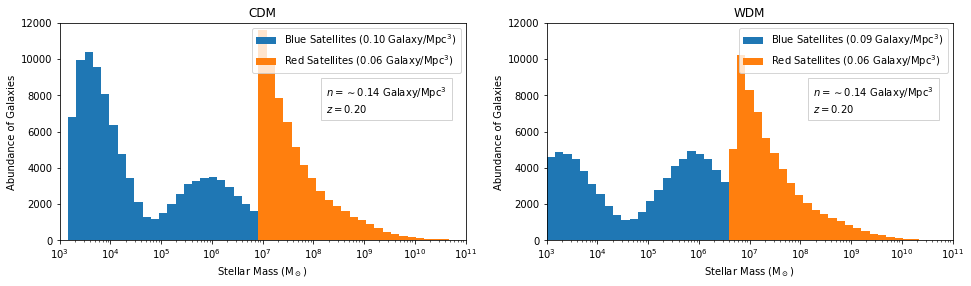

Color sanity check failed!
Color sanity check failed!


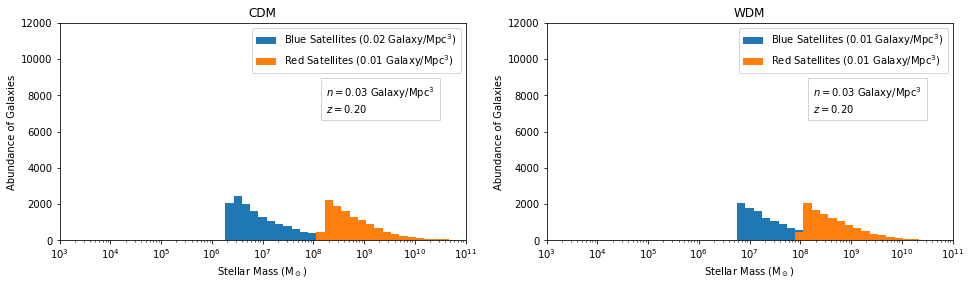

Color sanity check failed!
Color sanity check failed!


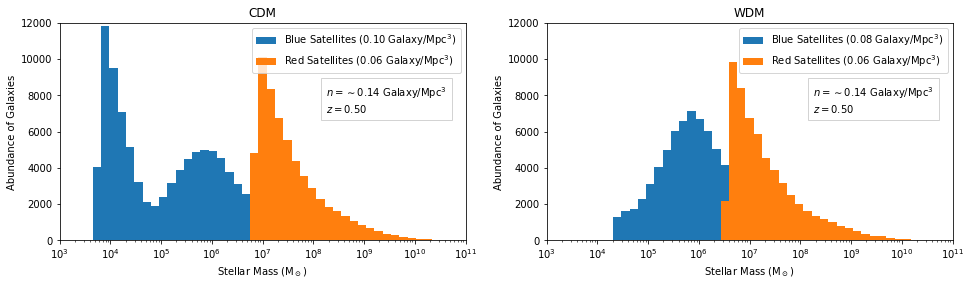

Color sanity check failed!
Color sanity check failed!


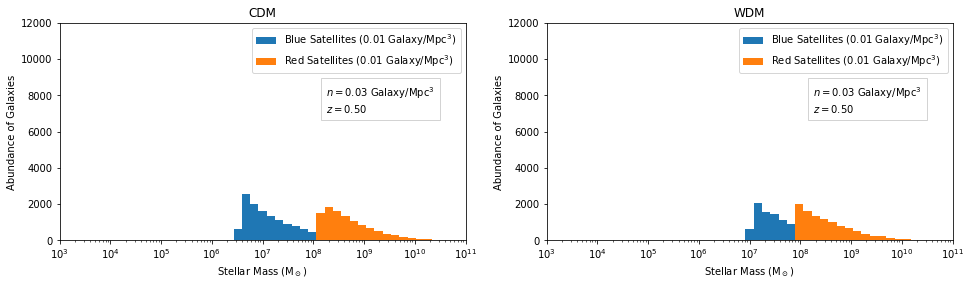

Color sanity check failed!
Color sanity check failed!


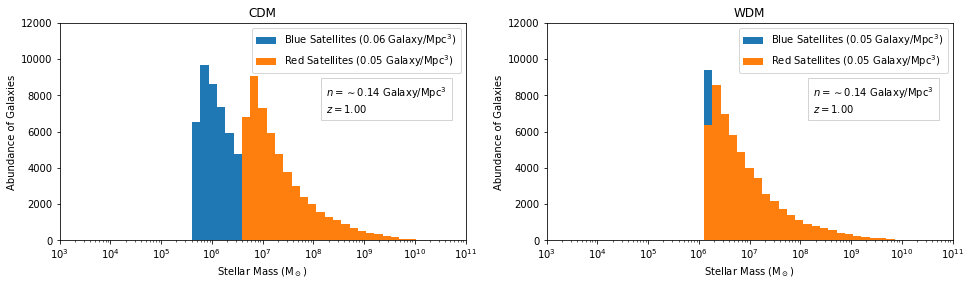

Color sanity check failed!
Color sanity check failed!


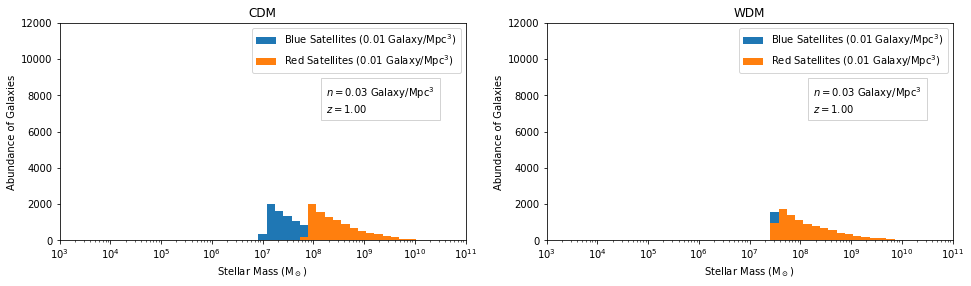

Color sanity check failed!
Color sanity check failed!


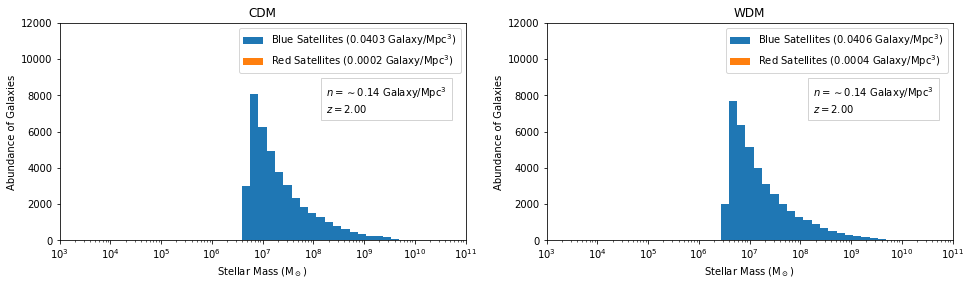

Color sanity check failed!
Color sanity check failed!


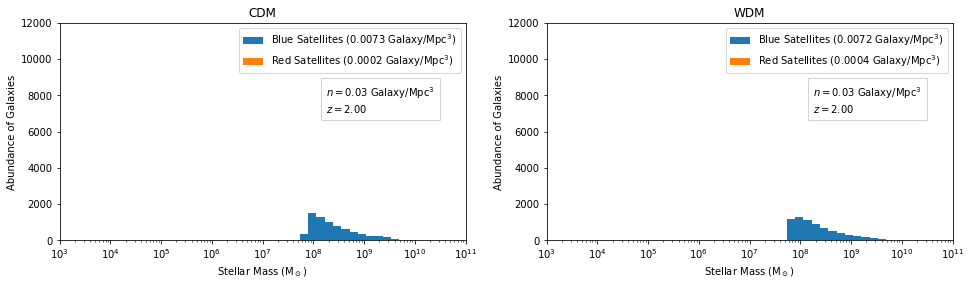

In [10]:
print('Plotting the stellar mass of red and blue satellite galaxies...\n')

for z, n_format in zip([0.2, 0.5, 1.00, 2.00],['{:.2f}','{:.2f}','{:.2f}','{:.4f}']):
    
    # repeat for all redshifts
    z = "{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n, n_text in zip([136834, 30000], ['\sim', ' ']):
        
        # set up the plots
        plt.figure(figsize=(16,4))
        grid = gridspec.GridSpec(1,2)
        grid.update(hspace = 0)
        grid0 = plt.subplot(grid[0])
        grid1 = plt.subplot(grid[1])
        
        for label, grid in zip(['CDM','WDM'], [grid0, grid1]):
    
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')

            # access galaxy color/mass/iscentral
            galaxy_color = galaxy['Colour'][:]
            galaxy_mass = galaxy['StellarMass'][:]
            galaxy_iscentral = galaxy['IsCentral'][:]

            # define the red and blue galaxies
            blue = np.array(galaxy_color)[np.where(galaxy_color < 0.5)]
            red = np.array(galaxy_color)[np.where(galaxy_color > 0.5)]

            # sort the galaxies in order of descending mass
            blue_ind_sorted = sorted(range(len(blue)), key=lambda k: galaxy_mass[k], reverse = True)
            red_ind_sorted = sorted(range(len(red)), key=lambda k: galaxy_mass[k], reverse = True)
            
            # determine the satellite blue and red galaxies 
            iscentral_blue = galaxy_iscentral[blue_ind_sorted[:n]]
            iscentral_red = galaxy_iscentral[red_ind_sorted[:n]]
            
            # determine the stellar mass of satellite blue and red galaxies 
            blue_mass = galaxy_mass[blue_ind_sorted[:n]][iscentral_blue==0]
            red_mass = galaxy_mass[red_ind_sorted[:n]][iscentral_red==0]
            
            # sanity check
            check = np.array([len(np.where(galaxy_color[blue_ind_sorted]>0.5)[0]),
                              len(np.where(galaxy_color[red_ind_sorted]<0.5)[0]),
                              len(np.where(galaxy_color[blue_ind_sorted[:n]][iscentral_blue==0]>0.5)[0]),
                              len(np.where(galaxy_color[red_ind_sorted[:n]][iscentral_red==0]<0.5)[0])])
            if check.any()!=np.zeros(len(check)).any():
                print('Color sanity check failed!')
            
            # label the plots
            label_blue = 'Blue Satellites ('+n_format.format(len(blue_mass)/(100**3))+' Galaxy/Mpc$^{3}$)'
            label_red = 'Red Satellites ('+n_format.format(len(red_mass)/(100**3))+' Galaxy/Mpc$^{3})$'
            textstr = '\n'.join((
                r'$n='+n_text+'{:.2f}'.format(n/(100**3))+'$ Galaxy/Mpc$^{3}$',
                r'$z=$'+z))
            props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
            
            # plot the stellar mass of satellite blue and red galaxies 
            bins=np.logspace(np.log10(1e3),np.log10(1e11), 50)
            grid.hist(blue_mass, bins = bins, label = label_blue)
            grid.hist(red_mass, bins = bins, label = label_red)
            grid.text(10**8.25, 8700, textstr, verticalalignment='top', bbox=props)
            grid.set_xlabel('Stellar Mass (M$_\odot$)')
            grid.set_ylabel('Abundance of Galaxies')
            grid.set_xlim(1e3,1e11)
            grid.set_ylim(0, 12000)
            grid.set_xscale("Log")
            grid.set_title(label)
            grid.legend()
        
        plt.show()

# Redo all blue and red calculations!
### Define a function to calculate fixed abundance

In [11]:
def fixed_abundance(ind, galaxy_mass):
    
    ind_sorted = sorted(ind, key=lambda k: galaxy_mass[k], reverse = True)

    # sanity check
    galaxy_mass_sorted = galaxy_mass[ind_sorted]
    check = all(galaxy_mass_sorted[i] >= galaxy_mass_sorted[i+1] for i in range(len(ind_sorted)-1))
    if check==False:
        print('General sanity check failed!')
            
    return ind_sorted

def positions(galaxy):
        
    # Access color/position/mass
    galaxy_color = galaxy['Colour'][:]
    galaxy_position = galaxy['GalaxyPos'][:]
    galaxy_mass = galaxy['StellarMass'][:]

    # sort the galaxies in order of descending mass
    ind_sorted = fixed_abundance(range(len(galaxy_mass)), galaxy_mass)
    blue_ind_sorted = fixed_abundance(np.where(galaxy_color < 0.5)[0], galaxy_mass)
    red_ind_sorted = fixed_abundance(np.where(galaxy_color > 0.5)[0], galaxy_mass)

    # sanity check
    blue_check = len(np.where(galaxy_color[blue_ind_sorted]>0.5)[0])
    red_check = len(np.where(galaxy_color[red_ind_sorted]<0.5)[0])
    if (blue_check!=0) | (red_check!=0):
        print('Color sanity check failed!')
            
    all_galaxy_position = galaxy_position[ind_sorted]
    blue_galaxy_position = galaxy_position[blue_ind_sorted]
    red_galaxy_position = galaxy_position[red_ind_sorted]
    
    return all_galaxy_position, blue_galaxy_position, red_galaxy_position, blue_ind_sorted, red_ind_sorted

### Start by recomputing the galaxy positions at fixed abundance

In [12]:
# iterate through each redshift
for z in [0.20,0.50,1.00,2.00]:
    
    z="{:.2f}".format(z) 
    
    for label in ['cdm','wdm']:
                
        # compute the galaxies at fixed abundance
        galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label.upper()+'_Galaxies_z'+z+'.hdf5', 'r')
        position, blue_position, red_position, blue_ind_sorted, red_ind_sorted = positions(galaxy)
                
        # Create an input folder 
        home="C:\\Users\\shife\\OneDrive\\Harvard_Stuff\\Astro_98"
        folder=home+"\\Input\\redshift\\"
        if not os.path.exists(folder):
            os.mkdir(folder)

        # iterate through each galaxy number density
        for n in [326952,136834,30000]:
            
            # label the galaxy positions correctly
            root="_galaxy_position_z"+z+"_n{:.2f}".format(n/100**3)+".txt"

            # save the galaxy positions
            np.savetxt(folder+label+root, position[:n], fmt = "%f %f %f")

            # save the blue/red galaxy positions
            np.savetxt(folder+label+"_blue"+root, blue_position[:n], fmt = "%f %f %f")
            np.savetxt(folder+label+"_red"+root, red_position[:n], fmt = "%f %f %f")
        
# Zip each input file
os.chdir(folder)
for zip_file in [file for file in os.listdir(folder) if file.endswith(".txt")]:
    subprocess.call(['zip','-ur','redshift.zip',zip_file])
os.chdir(home)

### Plot the correlation function!

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


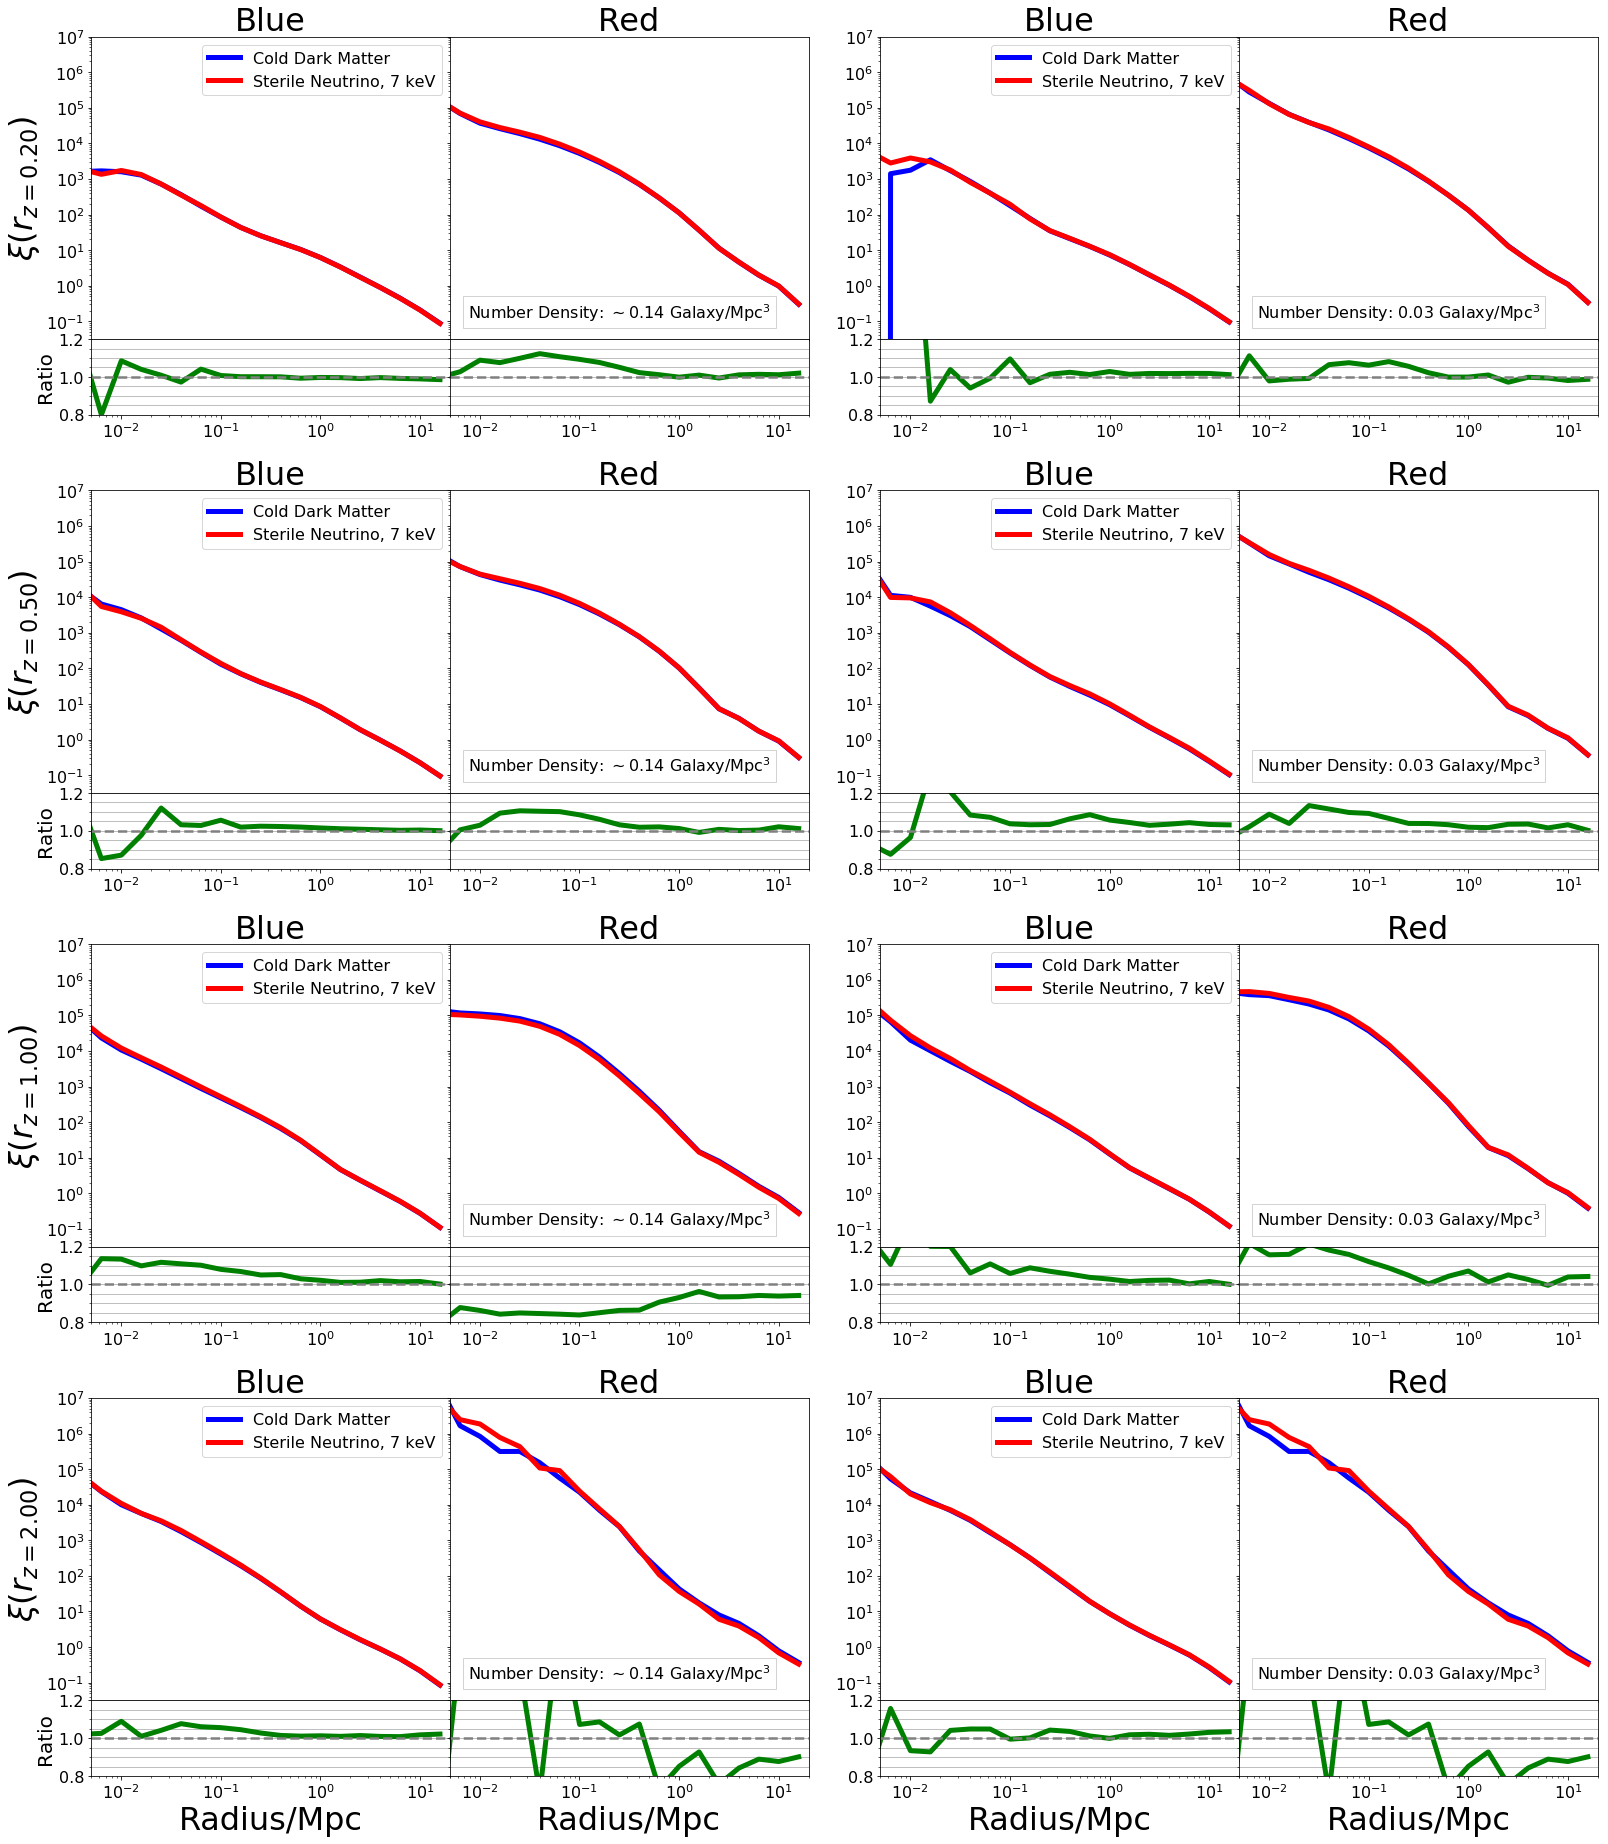

In [13]:
fig = plt.figure(figsize = (27, 32)) #28,40 #25,30
gs = gridspec.GridSpec(4, 2)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.14,0.03],['$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        CUTE_cdm_blue = np.genfromtxt("Output/redshift/corr_cdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_blue = np.genfromtxt("Output/redshift/corr_wdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        
        CUTE_cdm_red = np.genfromtxt("Output/redshift/corr_cdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_red = np.genfromtxt("Output/redshift/corr_wdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                                height_ratios=[4,1])
        
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid0.set_title('Blue',fontsize=32)
        grid0.legend(fontsize = 16)
        
        # second grid
        grid1 = fig.add_subplot(grid[1])
        grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid1.text(0.05, 0.125, textstr, transform = grid1.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid1.set_title('Red',fontsize=32)

        # third grid
        grid2 = fig.add_subplot(grid[2], sharex=grid0)
        grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, 
                       color = "green")
        
        # fourth grid
        grid3 = fig.add_subplot(grid[3])
        grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, 
                       color = "green")
        
        # details
        for grid in [grid0,grid1]:
            grid.set_ylim(10**-1.5, 10**7) #10**-1.25, 10**7
            
        for grid in [grid2,grid3]:
            grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
            grid.set_ylim(0.8, 1.2)
            grid.yaxis.grid(which = "both")
            
        for grid in [grid1,grid3]:
            grid.set_yticklabels([])
        
        for grid in [grid0,grid1,grid2,grid3]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
        
        if i%2==0:
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid2.set_ylabel("Ratio", fontsize = 20)            
        if i>5:
            grid2.set_xlabel("Radius/Mpc", fontsize = 32)
            grid3.set_xlabel("Radius/Mpc", fontsize = 32)
        i+=1
    
gs.update(wspace=0.1)
plt.show()

### Calculate the percentage of satellite galaxies in each model

In [14]:
print('Calculating the percentage of satellites in red and blue galaxies...\n')
print('{:<23}'.format(' ')+'{:<15}'.format('Blue')+'{:<15}'.format('Red')+'{:<17}'.format('Blue')+'Red\n')

for z in [0.2,0.5,1.00,2.00]:
    
    # repeat for all redshifts
    z="{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n in [136834,30000]:
        
        for label,tag in zip(['CDM','WDM'],['z='+z,'n={:.2f}'.format(n/(100**3))+' Galaxy/Mpc^3']):
    
            # compute the galaxies at fixed abundance
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')
            position, blue_position, red_position, blue_ind_sorted, red_ind_sorted = positions(galaxy)

            # determine the satellite blue and red galaxies 
            galaxy_iscentral = galaxy['IsCentral'][:]
            iscentral_blue = galaxy_iscentral[blue_ind_sorted[:n]]
            iscentral_red = galaxy_iscentral[red_ind_sorted[:n]]

            # calculate the percentage of satellite galaxies
            frac_blue = len(np.where(iscentral_blue == 0)[0])*100/n
            frac_red = len(np.where(iscentral_red == 0)[0])*100/n

            print('{:<23}'.format(tag)+label+': {:<10.3f}'.format(frac_blue)+label
                  +': {:<9.3f} N_gal: {:<9} N_gal: {}'.format(frac_red,len(iscentral_blue),len(iscentral_red)))

        print()

Calculating the percentage of satellites in red and blue galaxies...

                       Blue           Red            Blue             Red

z=0.20                 CDM: 13.916    CDM: 94.685    N_gal: 136834    N_gal: 136834
n=0.14 Galaxy/Mpc^3    WDM: 14.455    WDM: 94.746    N_gal: 136834    N_gal: 136834

z=0.20                 CDM: 12.977    CDM: 86.590    N_gal: 30000     N_gal: 30000
n=0.03 Galaxy/Mpc^3    WDM: 13.733    WDM: 86.893    N_gal: 30000     N_gal: 30000

z=0.50                 CDM: 24.316    CDM: 95.782    N_gal: 136834    N_gal: 136834
n=0.14 Galaxy/Mpc^3    WDM: 25.031    WDM: 95.929    N_gal: 136834    N_gal: 136834

z=0.50                 CDM: 21.900    CDM: 89.147    N_gal: 30000     N_gal: 30000
n=0.03 Galaxy/Mpc^3    WDM: 22.727    WDM: 89.770    N_gal: 30000     N_gal: 30000

z=1.00                 CDM: 36.828    CDM: 90.980    N_gal: 136834    N_gal: 136834
n=0.14 Galaxy/Mpc^3    WDM: 37.483    WDM: 89.120    N_gal: 136834    N_gal: 136834

z=1.00        

### Check the masses of blue and red satellite galaxies

Plotting the stellar mass of red and blue satellite galaxies...



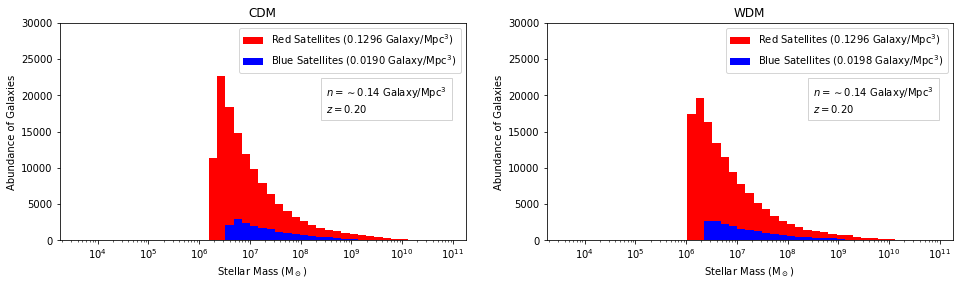

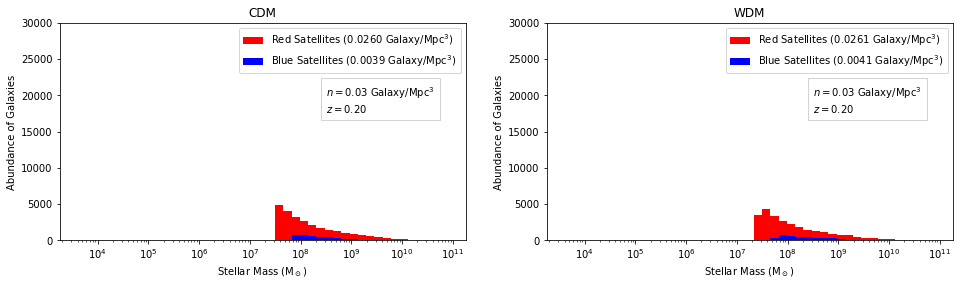

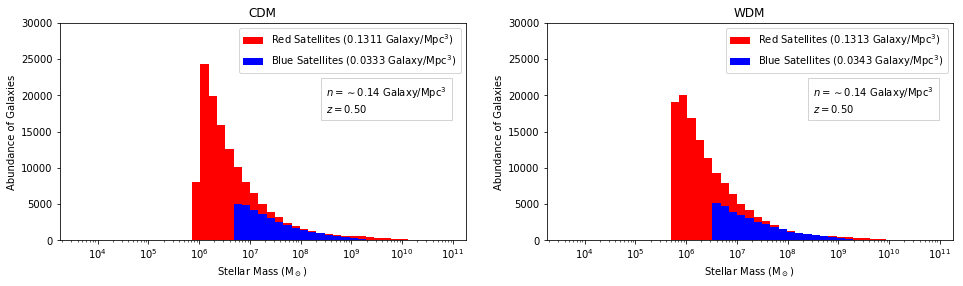

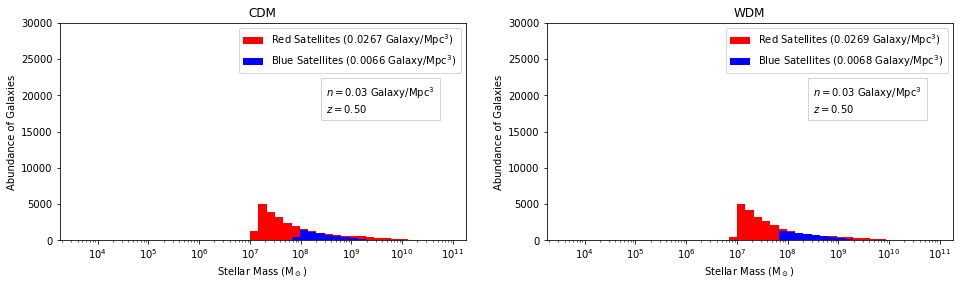

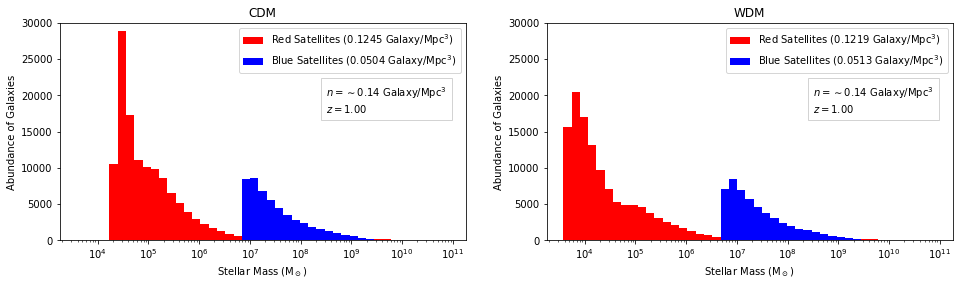

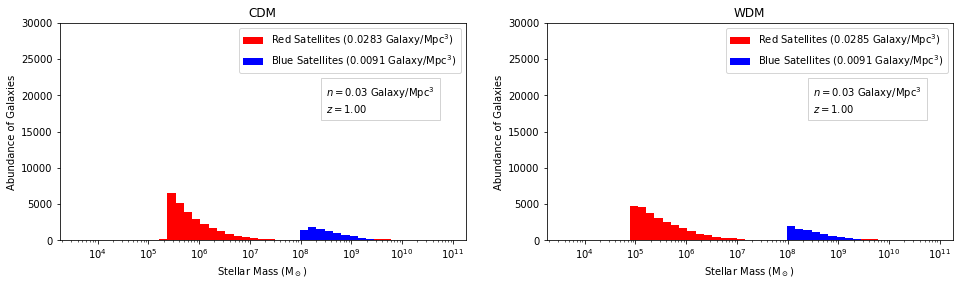

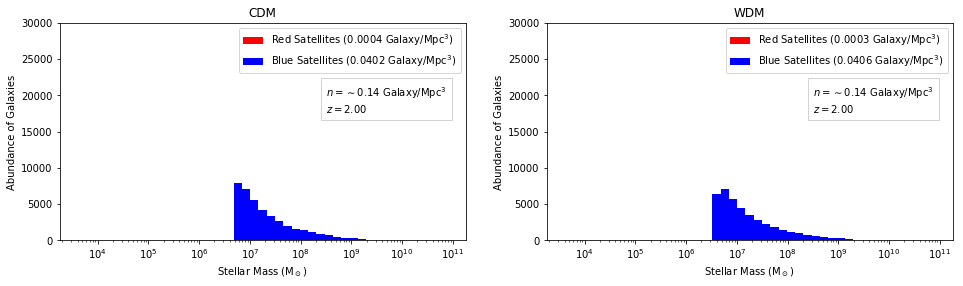

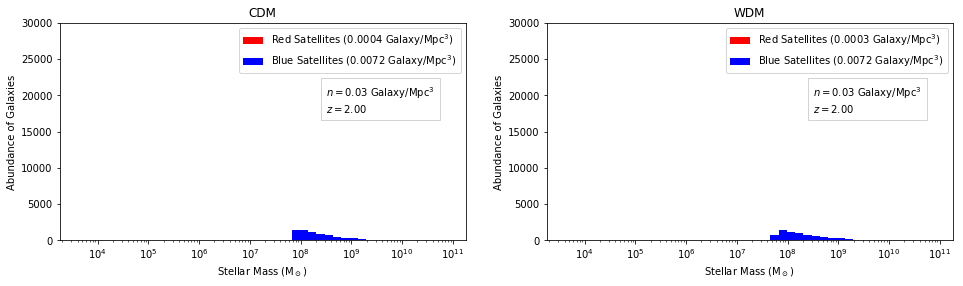

In [15]:
print('Plotting the stellar mass of red and blue satellite galaxies...\n')

for z in [0.2, 0.5, 1.00, 2.00]:
    
    # repeat for all redshifts
    z = "{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n, n_text in zip([136834, 30000], ['\sim', ' ']):
        
        # set up the plots
        plt.figure(figsize=(16,4))
        grid = gridspec.GridSpec(1,2)
        grid.update(hspace = 0)
        grid0 = plt.subplot(grid[0])
        grid1 = plt.subplot(grid[1])
        
        for label, grid in zip(['CDM','WDM'], [grid0, grid1]):
    
            # compute the galaxies at fixed abundance
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')
            position, blue_position, red_position, blue_ind_sorted, red_ind_sorted = positions(galaxy)

            # determine the satellite blue and red galaxies 
            galaxy_iscentral = galaxy['IsCentral'][:]
            iscentral_blue = galaxy_iscentral[blue_ind_sorted[:n]]
            iscentral_red = galaxy_iscentral[red_ind_sorted[:n]]

            # determine the stellar mass of satellite blue and red galaxies 
            galaxy_mass = galaxy['StellarMass'][:]
            blue_mass = galaxy_mass[blue_ind_sorted[:n]][iscentral_blue==0]
            red_mass = galaxy_mass[red_ind_sorted[:n]][iscentral_red==0]

            # label the plots
            label_blue = 'Blue Satellites ({:.4f}'.format(len(blue_mass)/(100**3))+' Galaxy/Mpc$^{3}$)'
            label_red = 'Red Satellites ({:.4f}'.format(len(red_mass)/(100**3))+' Galaxy/Mpc$^{3})$'
            textstr = '\n'.join((
                r'$n='+n_text+'{:.2f}'.format(n/(100**3))+'$ Galaxy/Mpc$^{3}$',
                r'$z=$'+z))
            props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)
            
            # plot the stellar mass of satellite blue and red galaxies 
            bins=np.logspace(3.25, 11.25, 50)
            grid.hist(red_mass, bins = bins, label = label_red, color = 'red')
            grid.hist(blue_mass, bins = bins, label = label_blue, color = 'blue')
            grid.text(10**8.5, 21750, textstr, verticalalignment='top', bbox=props)
            grid.set_xlabel('Stellar Mass (M$_\odot$)')
            grid.set_ylabel('Abundance of Galaxies')
            grid.set_xlim(10**3.25,10**11.25)
            grid.set_ylim(0, 30000)
            grid.set_xscale("Log")
            grid.set_title(label)
            grid.legend()
        
        plt.show()

# Recalculate the original blue/red galaxies at fixed abundance!
### Create the positions for each set of galaxies

In [16]:
for label in ['cdm','wdm']:
    
    galaxy = h5py.File('Data\COLOR_'+label.upper()+'_galaxies.hdf5', 'r')
    position, blue_position, red_position, blue_ind_sorted, red_ind_sorted = positions(galaxy)
    
    # Create an input folder 
    home = "C:\\Users\\shife\\OneDrive\\Harvard_Stuff\\Astro_98"
    folder = home+'\\Input\\color\\'
    if not os.path.exists(folder):
        os.mkdir(folder)
            
    # iterate through each galaxy number density
    for n in [326952,136834,30000]:

        # label the galaxy positions correctly
        root="_galaxy_position_z0.00_n{:.2f}".format(n/100**3)+".txt"
        
        # save the blue/red galaxy positions
        np.savetxt(folder+label+"_blue"+root, blue_position[:n], fmt = "%f %f %f")
        np.savetxt(folder+label+"_red"+root, red_position[:n], fmt = "%f %f %f")
        
# Zip each input file
os.chdir(folder)
for zip_file in [file for file in os.listdir(folder) if file.endswith(".txt")]:
    subprocess.call(['zip','-ur','color.zip',zip_file])
os.chdir(home)

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


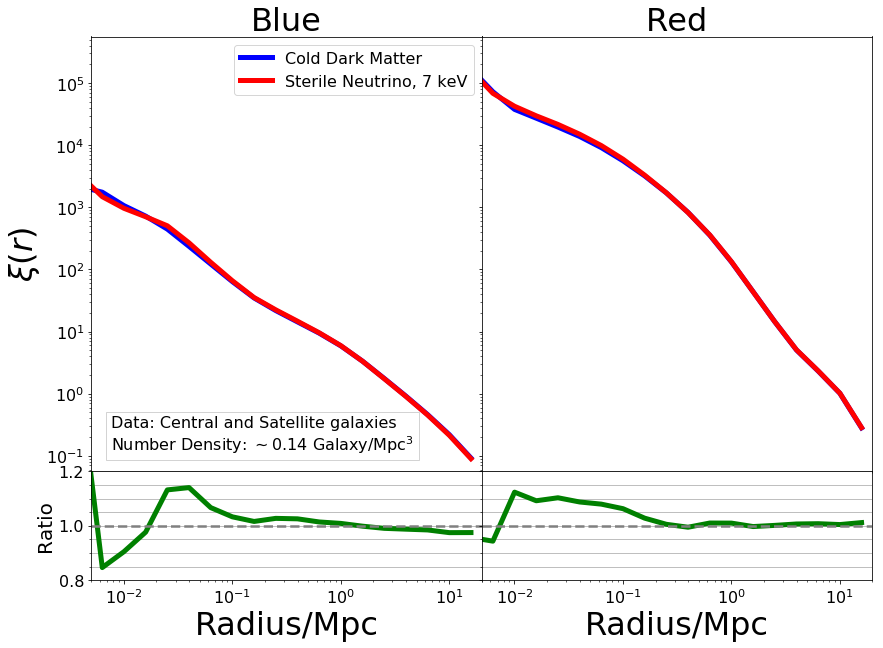

In [17]:
CUTE_cdm_blue = np.genfromtxt("Output/color/corr_cdm_blue_galaxy_position_z0.00_n0.14.txt", usecols = (0,1))
CUTE_wdm_blue = np.genfromtxt("Output/color/corr_wdm_blue_galaxy_position_z0.00_n0.14.txt", usecols = (0,1))

CUTE_cdm_red = np.genfromtxt("Output/color/corr_cdm_red_galaxy_position_z0.00_n0.14.txt", usecols = (0,1))
CUTE_wdm_red = np.genfromtxt("Output/color/corr_wdm_red_galaxy_position_z0.00_n0.14.txt", usecols = (0,1))

grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
grid.update(hspace = 0, wspace = 0)
plt.figure(figsize=(14,10))
    
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: $\sim$0.14 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.set_title(r"Blue", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1],  linewidth = 5, color = "blue")
grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1],  linewidth = 5, color = "red")
grid1.set_title(r"Red", fontsize = 32)

grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, color = "green")
grid2.set_xlabel("Radius/Mpc", fontsize = 32)
grid2.set_ylabel("Ratio", fontsize = 20)
grid2.tick_params(labelsize=16)
grid2.yaxis.grid(which = "both")

grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, color = "green")
grid3.set_xlabel("Radius/Mpc", fontsize = 32)
grid3.tick_params(labelsize=16)
grid3.yaxis.grid(which = "both")

for i in range(4):
    plt.subplot(grid[i]).minorticks_on()
    plt.subplot(grid[i]).set_xlim(5*10**-3, 2e1)
    plt.subplot(grid[i]).set_ylim(10**-1.25, 10**5.75)

for i in range(2,4):
    plt.subplot(grid[i]).set_ylim(0.8, 1.2)
    plt.subplot(grid[i]).axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    
for i in [1,3]:
    plt.subplot(grid[i]).set_yticklabels([]) 
    
plt.show()

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


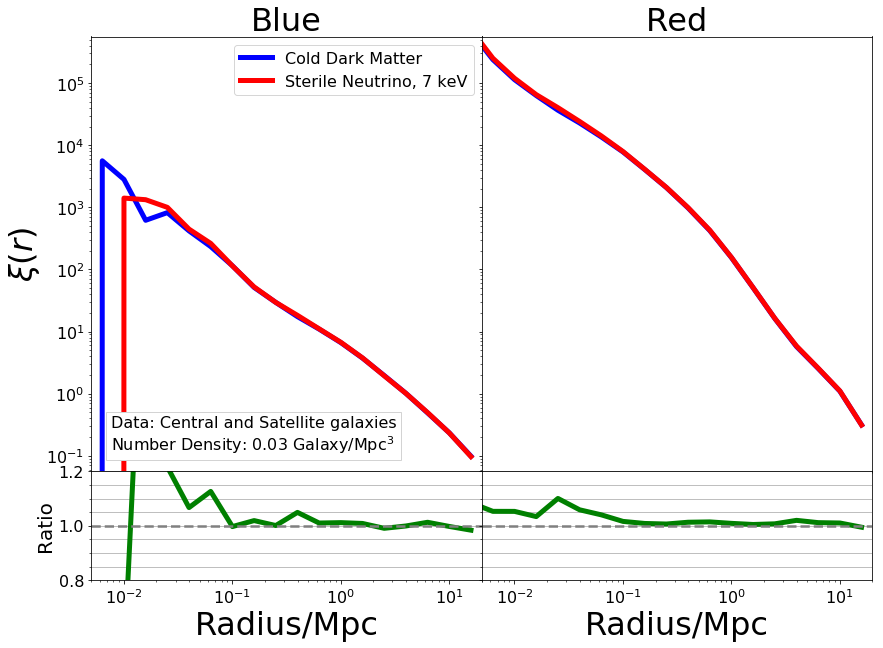

In [18]:
CUTE_cdm_blue = np.genfromtxt("Output/color/corr_cdm_blue_galaxy_position_z0.00_n0.03.txt", usecols = (0,1))
CUTE_wdm_blue = np.genfromtxt("Output/color/corr_wdm_blue_galaxy_position_z0.00_n0.03.txt", usecols = (0,1))

CUTE_cdm_red = np.genfromtxt("Output/color/corr_cdm_red_galaxy_position_z0.00_n0.03.txt", usecols = (0,1))
CUTE_wdm_red = np.genfromtxt("Output/color/corr_wdm_red_galaxy_position_z0.00_n0.03.txt", usecols = (0,1))

grid = gridspec.GridSpec(2,2, height_ratios = [4,1])
grid.update(hspace = 0, wspace = 0)
plt.figure(figsize=(14,10))
    
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])
grid2 = plt.subplot(grid[2])
grid3 = plt.subplot(grid[3])

textstr = '\n'.join((
    r'Data: Central and Satellite galaxies',
    r'Number Density: 0.03 Galaxy/Mpc$^{3}$'))
props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, 
             color = "red")
grid0.set_ylabel(r"$\xi(r)$", fontsize = 32)
grid0.set_title(r"Blue", fontsize = 32)
grid0.legend(fontsize = 16)
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.125, textstr, transform=grid0.transAxes, fontsize=16, verticalalignment='top', bbox=props)

grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1],  linewidth = 5, color = "blue")
grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1],  linewidth = 5, color = "red")
grid1.set_title(r"Red", fontsize = 32)

grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, color = "green")
grid2.set_xlabel("Radius/Mpc", fontsize = 32)
grid2.set_ylabel("Ratio", fontsize = 20)
grid2.tick_params(labelsize=16)
grid2.yaxis.grid(which = "both")

grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, color = "green")
grid3.set_xlabel("Radius/Mpc", fontsize = 32)
grid3.tick_params(labelsize=16)
grid3.yaxis.grid(which = "both")

for i in range(4):
    plt.subplot(grid[i]).minorticks_on()
    plt.subplot(grid[i]).set_xlim(5*10**-3, 2e1)
    plt.subplot(grid[i]).set_ylim(10**-1.25, 10**5.75)

for i in range(2,4):
    plt.subplot(grid[i]).set_ylim(0.8, 1.2)
    plt.subplot(grid[i]).axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
    
for i in [1,3]:
    plt.subplot(grid[i]).set_yticklabels([]) 
    
plt.show()